# Notebook to explore flow law parameter estimation 

Flow law parameter estimation (FLPE, pronounced "floppy") is the heart of Confluence. There are two stages. Stage 1 algorithms function at reach scale: this has been much of the heart of the DAWG's work over the past years. They function at the scale of a reach or several reaches. Stage 2 is the so-called integrator, which functions at the scale of basins or continents. 


In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/DAWGnotebooks/Path_files', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive


In [2]:
#reset working directory to distro folder
!pwd
import os
os.chdir("/content/drive/My Drive/DAWGnotebooks/dist_4.1")
!pwd

/content
/content/drive/My Drive/DAWGnotebooks/dist_4.1


In [3]:
import os
from netCDF4 import Dataset
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import json


This notebook relies on the swotdawgviz library. Use either the version included in this package or use an up-to-date version (https://github.com/klarnier/swotdawgviz)

In [4]:
# Using embedded version of swotdawgviz
from swotdawgviz.swotdawgviz import io as sdvio
from swotdawgviz.swotdawgviz import maps as sdvm
from swotdawgviz.swotdawgviz import plots as sdvpl

# Using up-to-date installed version of swotdawgviz
# from swotdawgviz import io as sdvio
# from swotdawgviz import maps as sdvm
# from swotdawgviz import plots as sdvpl

This library is supposed to run on a Jupyter notebook. Please be aware that some method may not work


# Stage 1 FLPE

There are six stage 1 FLPEs: BAM, HiVDI, MetroMan, MOMMA, SAD and SIC4DVar. 

In [5]:
# read in the list of reaches

# specify input directory
InputDir=Path('.')

# read in file with all reaches in the domain
reach_json=InputDir.joinpath('reaches.json')
with open(reach_json) as json_file:
    reaches = json.load(json_file)

#extract reach ids
domain_reachids=list()
for reach in reaches:
    domain_reachids.append(reach['reach_id'])


## GeoBAM

GeoBAM applies mass conservation flow law inversion on all the nodes within a reach, and thus operates on one reach at a time, and all output is within one file at a time. The GeoBAM flow law is:

$ \log{W} = \left( \dfrac{3}{5}\dfrac{1}{r} +1\right) \left( \log{Q} +\log{n} - \dfrac{5}{3} \log{D_b} + \dfrac{5}{3} \log{\dfrac{r+1}{r}} + \dfrac{5}{3} r \log{W_b} - \dfrac{1}{2} \log{S} \right)$

where $W$ is the measured width, $S$ is the measured slope, $D_b$ and $W_b$ are the bankfull width and depth, respectively, $r$ is a channel shape parameter, and $n$ is the resistance coefficient.

In [6]:
s1flpedir=InputDir.joinpath('s1-flpe')
gbdir=s1flpedir.joinpath('geobam').joinpath('output')

gb_con_dir=gbdir.joinpath('output_constrained')
gb_unc_dir=gbdir.joinpath('output_unconstrained')

gbfiles=os.listdir(gb_unc_dir)

print(gbfiles[0:10]) 

['74259000171_geobam.nc', '74259000161_geobam.nc', '74261000061_geobam.nc', '74261000081_geobam.nc', '74263000041_geobam.nc', '74259000111_geobam.nc', '74262100011_geobam.nc', '74263000011_geobam.nc', '74259000141_geobam.nc', '74259000201_geobam.nc']


In [7]:
# read and check out geobam data

reach='74267400441'

gbfile=gb_unc_dir.joinpath(reach + '_geobam.nc') # this reach is on the Kentucky River

gb_dataset = Dataset(gbfile)

print(gb_dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    reach_id: 74267400441
    dimensions(sizes): nt(18)
    variables(dimensions): int32 nt(nt)
    groups: r, logn, logWb, logDb, q


In [8]:
# GeoBAM runs three different Markov Chains to estimate discharge. let's extract the estimated bankfull depth
# nt=gb_dataset['nt'][:]
# t=list(nt.data)
# nt=len(t)

bamDbs=np.empty( (3,)  )

for c in range(3):
    bamDbs[c]=gb_dataset['logDb']['mean' + str(c+1)][:].filled(np.nan)
    
bamDb = np.mean(bamDbs)

gb_dataset.close()

print('GeoBAM bankfull depth for ',reach,'=',np.exp(bamDb))

GeoBAM bankfull depth for  74267400441 = 0.6368139037118674


In [9]:
# loop over reaches and extract depth
Db_gb=dict()
Db_gbs=list()

for reach in domain_reachids:
    gbfile=gb_con_dir.joinpath(str(reach) + '_geobam.nc') # this reach is on the Kentucky River
    
    Db_gb[str(reach)]=np.empty((1))
    
    try: 
        gb_dataset = Dataset(gbfile)
    except: 
        Db_gb[str(reach)]=-1.    

    if not Db_gb[str(reach)] == -1:                    
        try:
            data=gb_dataset['logDb']        
        except:
            Db_gb[str(reach)]=-1.    

        if not Db_gb[str(reach)]==-1:        
            for c in range(3):
                Db_gb[str(reach)]+=np.exp(gb_dataset['logDb']['mean' + str(c+1)][:].filled(np.nan))/3        
        
        gb_dataset.close()
        
    Db_gbs.append(float(Db_gb[str(reach)]))

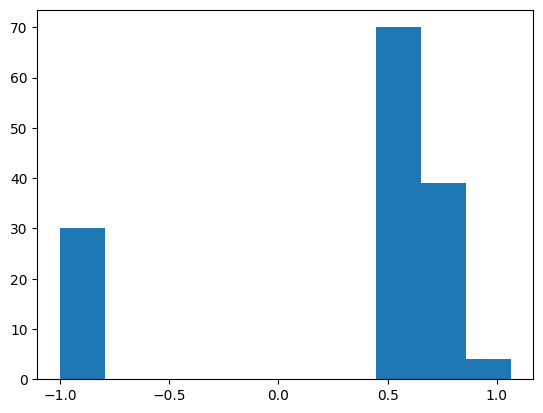

In [10]:
# summary of geobam bankfull depth estimates
fig,ax=plt.subplots()
plt.hist(Db_gbs)
plt.show()

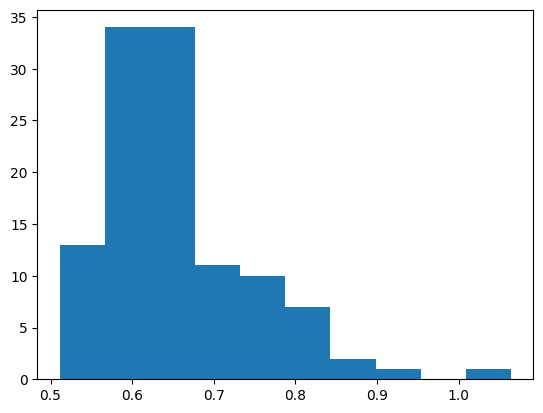

In [11]:
Db_gbs = np.array(Db_gbs)
Db_gbs = Db_gbs[Db_gbs>-1]
fig,ax=plt.subplots()
plt.hist(Db_gbs)
plt.show()

In [12]:
# plot map of bankfull depth - first create a map to attach them to

swot_nc_dir=InputDir.joinpath('swot/timeseries')

# sword_shp_dir='/Users/mtd/Data/SWOT/SWORD/SWORD/Reaches_Nodes/shp/NA/'
# sword_shp_dir='/home/kevin/Documents/SWOT/DATABASES/SWORD/V11/shp/NA/'

sword_shp_dir=InputDir.joinpath('sword/shp/NA')


collection = sdvio.SwotObservationsCollection(swot_nc_dir)

sword_hb74_reaches = sdvio.SwordShapefile(os.path.join(sword_shp_dir, "na_sword_reaches_hb74_v11.shp"),
                                          reaches_list=collection.reaches_list)

rmap = sdvm.ReachesMap(sword_hb74_reaches.dataset)


In [13]:
# add bankfull depth the rmap object
rmap._dataset['geobam_db']=-1.

for reachid in domain_reachids:
    if not np.isnan(Db_gb[str(reachid)]):
        rmap._dataset.loc[rmap._dataset['reach_id'].astype(str)==str(reachid),['geobam_db']]=Db_gb[str(reachid)]
    

rmap._json_dataset = rmap._dataset.to_json()    

In [14]:
#map Geobam bankfull depth
geobamdb_map = rmap.get_centerlines_map(varname="geobam_db",varlimits=[0,2])
geobamdb_map

Output hidden; open in https://colab.research.google.com to view.

## MetroMan

MetroMan runs on a so-called "Inversion Set" of reaches all at once, and so data is stored in files that contain output from all sets. 


In [15]:
mmdir=s1flpedir.joinpath('metroman').joinpath('output').joinpath('output_unconstrained')
mmfiles=os.listdir(mmdir)

print(mmfiles[0:10]) 

['74267100051-74267100041-74267100031_metroman.nc', '74266300061-74266300051-74266300041-74266300031-74266300021-74266300011_metroman.nc', '74266300061-74266300051-74266300041-74266300031-74266300021_metroman.nc', '74267300191-74267300181-74267300171_metroman.nc', '74267300311-74267300301-74267300291-74267300281_metroman.nc', '74269500101-74269500091-74269500081_metroman.nc', '74266300031-74266300021-74266300011-74266100011_metroman.nc', '74269300021-74269300011-74269100111_metroman.nc', '74265000071-74265000061-74265000051-74265000041_metroman.nc', '74269500161-74269500151-74269500141-74269500131_metroman.nc']


In [16]:
mmfile=mmdir.joinpath('74266300051-74266300041-74266300031-74266300021-74266300011_metroman.nc') # this set is on the Wabash River

mm_dataset = Dataset(mmfile)

print(mm_dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    set_id: 74266300051-74266300041-74266300031-74266300021-74266300011_metroman.nc
    valid: 1
    dimensions(sizes): nr(5), nt(36)
    variables(dimensions): int32 nr(nr), int32 nt(nt), int64 reach_id(nr), float64 A0hat(nr), float64 nahat(nr), float64 x1hat(nr), float64 allq(nr, nt), float64 q_u(nr, nt)
    groups: 


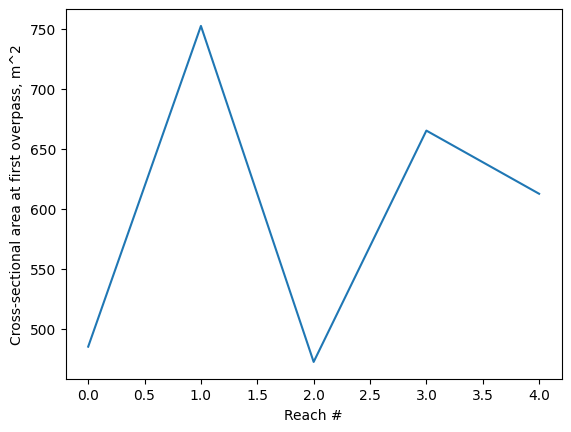

In [17]:
A0=mm_dataset['A0hat'][:].filled(np.nan)

mm_dataset.close()

fig,ax=plt.subplots()
ax.plot(A0)
plt.ylabel('Cross-sectional area at first overpass, m^2')
plt.xlabel('Reach #')
plt.show()


## MOMMA

MOMMA files are one per reach. Flow law parameters are chosen to make the mean discharge match the prior, rather than solving the McFLI problem.

In [18]:
modir=s1flpedir.joinpath('momma').joinpath('output').joinpath('output_unconstrained')
mofiles=os.listdir(modir)
print(mofiles[0:10]) 

['74267100041_momma.nc', '74270100051_momma.nc', '74267100051_momma.nc', '74266300041_momma.nc', '74269100081_momma.nc', '74266300051_momma.nc', '74267300231_momma.nc', '74267900111_momma.nc', '74267400221_momma.nc', '74269500071_momma.nc']


In [19]:
# let's loop over these and compute a momma average dishcarge for each reach

Qbar_momma=dict()

for reachid in domain_reachids:
    mofile=str(reachid) + '_momma.nc'
    mofilepath=modir.joinpath(mofile)
    
    if mofilepath.exists():
        mo_dataset = Dataset(mofilepath)
        Qfile=mo_dataset['Q'][:].filled(np.nan)
        Qbar_momma[str(reachid)]=np.nanmean(Qfile)
        mo_dataset.close()        
    else:
        Qbar_momma[str(reachid)]=np.nan
        

<ipython-input-19-850d2c8ce6b2>:12: RuntimeWarning: Mean of empty slice
  Qbar_momma[str(reachid)]=np.nanmean(Qfile)


In [20]:
# create a map to show the MOMMA average discharge

# add Momma discharge to the rmap object
rmap._dataset['QMomma']=-1.

for reachid in domain_reachids:
    if not np.isnan(Qbar_momma[str(reachid)]):
        rmap._dataset.loc[rmap._dataset['reach_id'].astype(str)==str(reachid),['QMomma']]=Qbar_momma[str(reachid)]
    

rmap._json_dataset = rmap._dataset.to_json()    


In [21]:
#map Momma Discharge
momma_map = rmap.get_centerlines_map(varname="QMomma",varlimits=[0,2000])
momma_map

Output hidden; open in https://colab.research.google.com to view.

## H2iVDI

H2iVDI files are one per reach. Flow law parameters are computed to match the discharge infered by the Full St-Venant model using 4DVAR.

<span style="color:red"> Warning: H2iVDI only ran on 75/213 reaches (reaches with valid observations)</span>

In [22]:
h2ivdidir=s1flpedir.joinpath('hivdi').joinpath('output').joinpath('output_unconstrained')
h2ivdifiles=os.listdir(h2ivdidir)
print(h2ivdifiles[0:10]) 

['74267100031_hivdi.nc', '74267100051_hivdi.nc', '74267100041_hivdi.nc', '74267300191_hivdi.nc', '74267300181_hivdi.nc', '74267300171_hivdi.nc', '74259000061_hivdi.nc', '74259000031_hivdi.nc', '74259000041_hivdi.nc', '74259000051_hivdi.nc']


In [23]:
# let's loop over these and retrieve H2iVDI unobserved flow area (A0)

A0_h2ivdi=dict()

count = 0
for reachid in domain_reachids:
    h2ivdifile=str(reachid) + '_hivdi.nc'
    h2ivdifilepath=h2ivdidir.joinpath(h2ivdifile)
    
    if h2ivdifilepath.exists():
        h2ivdi_dataset = Dataset(h2ivdifilepath)
        reach_dataset = h2ivdi_dataset.groups["reach"]
        A0file=reach_dataset['A0'][0]
        A0_h2ivdi[str(reachid)]=float(A0file)
        h2ivdi_dataset.close()
        count += 1
    else:
        A0_h2ivdi[str(reachid)]=np.nan


<ipython-input-23-a76ac027af5d>:14: UserWarning: Warning: converting a masked element to nan.
  A0_h2ivdi[str(reachid)]=float(A0file)


In [24]:
# create a map to show the H2iVDI unobserved flow area (A0)

# add H2iVDI A0 to the rmap object
rmap._dataset['A0H2iVDI']=-1.

for reachid in domain_reachids:
    if not np.isnan(A0_h2ivdi[str(reachid)]):
        rmap._dataset.loc[rmap._dataset['reach_id'].astype(str)==str(reachid),['A0H2iVDI']]=A0_h2ivdi[str(reachid)]
    

rmap._json_dataset = rmap._dataset.to_json()    


In [25]:
#map H2iVDI unobserved flow area (A0)
h2ivdi_map = rmap.get_centerlines_map(varname="A0H2iVDI",varlimits=[1000,10000])
h2ivdi_map

Output hidden; open in https://colab.research.google.com to view.

Here we compare three products for H2iVDI. The first two products are the **constrained** and **unconstrained** products using the *classic* HiVDI toolchain (Full St-Venant+4DVAR) and the third is the new *surrogate* (hybrid) toolchain which uses machine learning technics to estimate better priors of discharge and $A_0$

In [26]:
#--------------------------------
# REQUIRES UP-TO-DATE swotdawgviz
#--------------------------------

reachid = 74259000031
# Load SoS data
sosdir=InputDir.joinpath('sos')
sosdir_constrained=sosdir.joinpath("constrained")
sosdir_unconstrained=sosdir.joinpath("unconstrained")
sos_unconstrained = sdvio.SosNetCDF(sosdir_unconstrained.joinpath("na_sword_v11_SOS_priors.nc"), verbose=False)
sos_constrained = sdvio.SosNetCDF(sosdir_constrained.joinpath("na_sword_v11_SOS_priors.nc"), verbose=False)

# Retrieve in-situ data and priors
reach_data = sos_unconstrained.get_reach(reachid)
wbm_mean_q = float(reach_data["model_mean_q"])
reach_data = sos_constrained.get_reach(reachid)
usgs_mean_q = float(reach_data["usgs_mean_q"])
grades_mean_q = float(reach_data["model_mean_q"])

# Load HiVDI output
h2ivdidir_constrained=s1flpedir.joinpath('hivdi').joinpath('output').joinpath('output_constrained')
h2ivdi_constrained = sdvio.OutputH2iVDI(h2ivdidir_constrained.joinpath("%i_hivdi.nc" % reachid))
h2ivdidir_unconstrained=s1flpedir.joinpath('hivdi').joinpath('output').joinpath('output_unconstrained')
h2ivdi_unconstrained = sdvio.OutputH2iVDI(h2ivdidir_unconstrained.joinpath("%i_hivdi.nc" % reachid))
h2ivdidir_surrogate=s1flpedir.joinpath('hivdi').joinpath('output').joinpath('surrogate')
h2ivdi_surrogate = sdvio.OutputH2iVDI(h2ivdidir_surrogate.joinpath("%i_hivdi.nc" % reachid))

# Make plot
statuses = "const.:%i,unconst.:%i" % (h2ivdi_constrained.status(), h2ivdi_unconstrained.status())
statuses += ",surrogate:%i" % h2ivdi_surrogate.status()
qplot = sdvpl.DischargePlot(title='Reach %i, status:%s' % (reachid, statuses), date_units="days_since_2000")
qplot.add_prior("WBM mean Q", wbm_mean_q, color="red", linestyle="dash")
qplot.add_prior("GRADES mean Q", grades_mean_q, color="red", linestyle=None)
if not np.isnan(usgs_mean_q):
    qplot.add_prior("USGS mean Q", usgs_mean_q, color="green", linestyle=None)
qplot.add_product("H2iVDI (constrained)", h2ivdi_constrained.Q, times=h2ivdi_constrained.t,
                  color="blue", linestyle=None)
qplot.add_product("H2iVDI (unconstrained)", h2ivdi_unconstrained.Q, times=h2ivdi_unconstrained.t,
                  color="blue", linestyle="dash")
qplot.add_product("H2iVDI (surrogate)", h2ivdi_surrogate.Q, times=h2ivdi_surrogate.t,
                  color="cyan", linestyle="dash")
qplot.render(backend="plotly")

<ipython-input-26-3bbb9821e1ba>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wbm_mean_q = float(reach_data["model_mean_q"])
<ipython-input-26-3bbb9821e1ba>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  usgs_mean_q = float(reach_data["usgs_mean_q"])
<ipython-input-26-3bbb9821e1ba>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  grades_mean_q = float(reach_data["model_mean_q"])
/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Comparison of discharge estimated by 3 different algorithms
Here we compare the discharge timeseries infered by algorithms MetroMan, MOMMA and H2iVDI on a single reach. Note that these are reading discharge created internally in each stage 1 FLPE algorithm in Confluence. These values will differ from those created after the integrator, and after the offline discharge is created.

In [27]:
reachid = 74264100171

In [28]:
# Retrieve MetroMan discharge
mmfile=mmdir.joinpath('74264100171-74264100161-74264100151_metroman.nc') # this set is on the Cumberland River
mm_dataset = Dataset(mmfile)
QMetroMan = mm_dataset["allq"][0,:]


In [29]:
# Retrieve MOMMA discharge
mofile=str(reachid) + '_momma.nc'
mofilepath=modir.joinpath(mofile)
if mofilepath.exists():
    mo_dataset = Dataset(mofilepath)
    QMomma = mo_dataset['Q'][:].filled(np.nan)
    

In [30]:
# Retrieve H2iVDI discharge
h2ivdifile=str(reachid) + '_hivdi.nc'
h2ivdifilepath=h2ivdidir.joinpath(h2ivdifile)
if h2ivdifilepath.exists():
    h2ivdi_dataset = Dataset(h2ivdifilepath)
    reach_dataset = h2ivdi_dataset.groups["reach"]
    QH2iVDI = reach_dataset['Q'][:].filled(np.nan)
    

In [31]:
# Retrieve GeoBam discharge
gbfile=str(reachid) + '_geobam.nc'
gbfilepath=gb_unc_dir.joinpath(gbfile)
if gbfilepath.exists():
    gb_dataset = Dataset(gbfilepath)    
    q_dataset=gb_dataset.groups['q']
    q1 = q_dataset['q1'][:].filled(np.nan)
    q2 = q_dataset['q2'][:].filled(np.nan)
    q3 = q_dataset['q3'][:].filled(np.nan)
    qs=np.vstack((q1,q2,q3))
    QGeoBAM=np.nanmean(qs, axis=0)


<ipython-input-31-e16ca58ee476>:11: RuntimeWarning:

Mean of empty slice



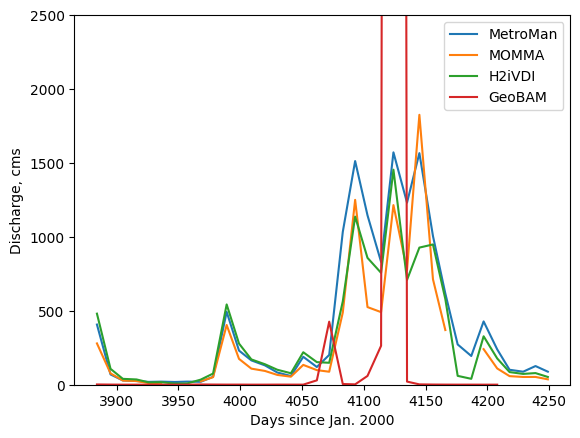

In [32]:
# Compare the discharge timeseries
fig,ax=plt.subplots()
ax.plot(h2ivdi_dataset['nt'][:], QMetroMan, label="MetroMan")
ax.plot(h2ivdi_dataset['nt'][:], QMomma, label="MOMMA")
ax.plot(h2ivdi_dataset['nt'][:], QH2iVDI, label="H2iVDI")
ax.plot(h2ivdi_dataset['nt'][:], QGeoBAM, label="GeoBAM")

ax.set_ylim(0.0, 2500)

plt.ylabel('Discharge, cms')
plt.xlabel('Days since Jan. 2000')
plt.legend()
plt.show()

In [33]:
h2ivdi_dataset['nt']

<class 'netCDF4._netCDF4.Variable'>
int32 nt(nt)
    units: day
    long_name: nt
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of -2147483647 used

# Stage 2 FLPE

In this stage, we impose a couple of constraints on our retrievals. First, we require that discharge be conserved across river networks. Second, we use gages to constrain the discharge values. We accomplish this using the (still unpublished) algorithm called "mean optimization integrator" or MOI. MOI "integrates" information from across the river network to refine the flow law parameter estimates for both the constrained and the unconstrained branches of discharge.

In [34]:
# all discharge for all algorithms are stored in reach-by-reach integrator files

stage2_dir=InputDir.joinpath('s2-flpe').joinpath('output')
s2_files=os.listdir(stage2_dir)
print(s2_files[0:10]) 

['74267700251_integrator.nc', '74270100191_integrator.nc', '74267400351_integrator.nc', '74267400061_integrator.nc', '74265000061_integrator.nc', '74270500011_integrator.nc', '74266100011_integrator.nc', '74267300061_integrator.nc', '74269400061_integrator.nc', '74267400011_integrator.nc']


In [35]:
Qbar_mm2=dict()
sbQrel=dict()

for reachid in domain_reachids:
    mm2_file=str(reachid) + '_integrator.nc'
    mm2_filepath=stage2_dir.joinpath(mm2_file)
    
    if mm2_filepath.exists():
        mm2_dataset = Dataset(mm2_filepath)
        Qfile=mm2_dataset['metroman/qbar_basinScale'][:].filled(np.nan)
        Qbar_mm2[str(reachid)]=np.nanmean(Qfile)
        
        sbQrel[str(reachid)]=mm2_dataset['metroman/sbQ_rel'][:].filled(np.nan)
        
        mm2_dataset.close()
    else:
        Qbar_mm2[str(reachid)]=np.nan
        

In [36]:
# add integrated MetroMan discharge and uncertainty to the rmap object
rmap._dataset['QMetroMan2']=-1.
rmap._dataset['sbQrel']=0.

for reachid in domain_reachids:
    if not np.isnan(Qbar_mm2[str(reachid)]):
        rmap._dataset.loc[rmap._dataset['reach_id'].astype(str)==str(reachid),['QMetroMan2']]=Qbar_mm2[str(reachid)]
        rmap._dataset.loc[rmap._dataset['reach_id'].astype(str)==str(reachid),['sbQrel']]=sbQrel[str(reachid)]
    

rmap._json_dataset = rmap._dataset.to_json()    


In [37]:
# map MetroMan discharge
mm2_map = rmap.get_centerlines_map(varname="QMetroMan2",varlimits=[0,7500])
mm2_map

Output hidden; open in https://colab.research.google.com to view.

In [38]:
# map MetroMan discharge uncertainty
mm_sbq_map = rmap.get_centerlines_map(varname="sbQrel",varlimits=[0,.5])
mm_sbq_map


Output hidden; open in https://colab.research.google.com to view.